In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, TensorDataset
from torchvision.models import resnet50, ResNet50_Weights
import os
from sklearn.model_selection import train_test_split
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


In [13]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Runing on {str(device)}")

# Define dataset paths
torch_train_path = "./animals90TrainDataset.pt"
torch_test_path = "./animals90TestDataset.pt"
torch_val_path = "./animals90ValDataset.pt"

# Define class names
class_names =  [
    "antelope", "badger", "bat", "bear", "bee", "beetle", "bison", "boar", "butterfly",
    "cat", "caterpillar", "chimpanzee", "cockroach", "cow", "coyote", "crab", "crow",
    "deer", "dog", "dolphin", "donkey", "dragonfly", "duck", "eagle", "elephant",
    "flamingo", "fly", "fox", "goat", "goldfish", "goose", "gorilla", "grasshopper",
    "hamster", "hare", "hedgehog", "hippopotamus", "hornbill", "horse", "hummingbird",
    "hyena", "jellyfish", "kangaroo", "koala", "ladybugs", "leopard", "lion", "lizard",
    "lobster", "mosquito", "moth", "mouse", "octopus", "okapi", "orangutan", "otter",
    "owl", "ox", "oyster", "panda", "parrot", "pelecaniformes", "penguin", "pig",
    "pigeon", "porcupine", "possum", "raccoon", "rat", "reindeer", "rhinoceros",
    "sandpiper", "seahorse", "seal", "shark", "sheep", "snake", "sparrow", "squid",
    "squirrel", "starfish", "swan", "tiger", "turkey", "turtle", "whale", "wolf",
    "wombat", "woodpecker", "zebra"
]
class_to_idx = {class_name: idx for idx, class_name in enumerate(class_names)}
num_classes = len(class_names)

# Load dataset from Torch tensor file
print("Loading dataset from Torch tensor file...")
train_data = torch.load(torch_train_path)
print("Dataset loaded successfully.")
test_data = torch.load(torch_test_path)
print("Test dataset loaded successfully.")
val_dataset = torch.load(torch_val_path)
print("Validation dataset loaded successfully.")
train_images, train_labels = train_data["images"], train_data["labels"]
test_images, test_labels = test_data["images"], test_data["labels"]
val_images, val_labels = val_dataset["images"], val_dataset["labels"]

train_dataset = TensorDataset(train_images, train_labels)
test_dataset = TensorDataset(test_images, test_labels)
val_dataset = TensorDataset(val_images, val_labels)

print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}, Test samples: {len(test_dataset)}")


Runing on cpu
Loading dataset from Torch tensor file...
Dataset loaded successfully.
Test dataset loaded successfully.
Validation dataset loaded successfully.
Train samples: 4320, Val samples: 1080, Test samples: 100


In [4]:
# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [5]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        
        # Convolutional feature extractor
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),  # (3, 224, 224) -> (32, 112, 112)
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),  # (32, 112, 112) -> (64, 56, 56)
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),  # (64, 56, 56) -> (128, 28, 28)
        )

        self.classifier = nn.Sequential(
            nn.Linear(128 * 28 * 28, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes),
        )
    
    def forward(self, x):
        x = self.features(x)               # extract features through conv layers
        x = x.view(x.size(0), -1)         # flatten for the classifier
        x = self.classifier(x)            # final classification
        return x

In [ ]:

model = SimpleCNN(num_classes=num_classes)
model.to(device)
print(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)  # Adjust as needed

epochs = 100

In [7]:
def plot_loss_and_accuracy(train_losses, val_losses, train_accs, val_accs):
    """
    Plots the training/validation loss and accuracy curves in separate charts.
    """
    # Plot loss
    plt.figure()
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.legend()
    plt.show()

    # Plot accuracy
    plt.figure()
    plt.plot(train_accs, label='Train Acc')
    plt.plot(val_accs, label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy per Epoch')
    plt.legend()
    plt.show()

In [8]:
train_losses = []
train_accs   = []
val_losses   = []
val_accs     = []

for epoch in range(epochs):
    # --- Training ---
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images_batch, labels_batch in train_loader:
        images_batch = images_batch.to(device)
        labels_batch = labels_batch.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images_batch)
        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer.step()
        
        # Track training loss
        running_loss += loss.item() * images_batch.size(0)
        
        # Compute training accuracy
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels_batch).sum().item()
        total += labels_batch.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct / total

    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)
    
    print(f"Epoch [{epoch+1}/{epochs}] - "
          f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}")

    # --- Validation ---
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for images_batch, labels_batch in val_loader:
            images_batch = images_batch.to(device)
            labels_batch = labels_batch.to(device)

            outputs = model(images_batch)
            loss = criterion(outputs, labels_batch)
            
            # Track validation loss
            val_running_loss += loss.item() * images_batch.size(0)
            # Compute validation accuracy
            _, predicted = outputs.max(1)
            val_correct += predicted.eq(labels_batch).sum().item()
            val_total += labels_batch.size(0)
    
    val_epoch_loss = val_running_loss / len(val_loader.dataset)
    val_epoch_acc = val_correct / val_total
    
    val_losses.append(val_epoch_loss)
    val_accs.append(val_epoch_acc)
    
    print(f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}\n")


Epoch [1/100] - Train Loss: 4.5037, Train Acc: 0.0215
Val Loss: 4.3964, Val Acc: 0.0352

Epoch [2/100] - Train Loss: 4.3606, Train Acc: 0.0387
Val Loss: 4.2863, Val Acc: 0.0648

Epoch [3/100] - Train Loss: 4.1814, Train Acc: 0.0701
Val Loss: 4.1184, Val Acc: 0.1000

Epoch [4/100] - Train Loss: 3.8743, Train Acc: 0.1187
Val Loss: 3.9227, Val Acc: 0.1472

Epoch [5/100] - Train Loss: 3.4477, Train Acc: 0.1998
Val Loss: 3.6651, Val Acc: 0.2194

Epoch [6/100] - Train Loss: 2.8966, Train Acc: 0.2972
Val Loss: 3.5258, Val Acc: 0.2509

Epoch [7/100] - Train Loss: 2.3845, Train Acc: 0.3995
Val Loss: 3.3575, Val Acc: 0.2981

Epoch [8/100] - Train Loss: 1.9347, Train Acc: 0.4926
Val Loss: 3.3180, Val Acc: 0.3194

Epoch [9/100] - Train Loss: 1.5719, Train Acc: 0.5764
Val Loss: 3.2926, Val Acc: 0.3296

Epoch [10/100] - Train Loss: 1.2281, Train Acc: 0.6562
Val Loss: 3.2897, Val Acc: 0.3380

Epoch [11/100] - Train Loss: 1.0004, Train Acc: 0.7194
Val Loss: 3.4692, Val Acc: 0.3500

Epoch [12/100] - Tr

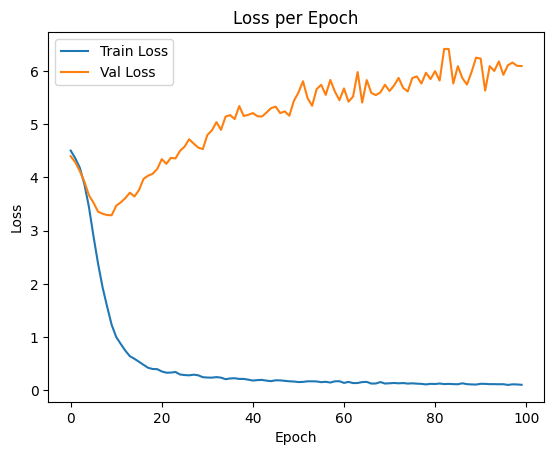

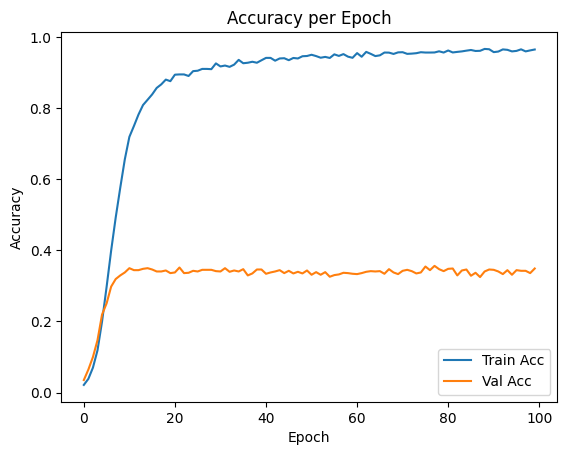

In [9]:
# Plot Loss and Accuracy
plot_loss_and_accuracy(train_losses, val_losses, train_accs, val_accs)


In [10]:
# Testing
model.eval()
test_loss = 0.0
test_correct = 0
test_total = 0

with torch.no_grad():
    for images_batch, labels_batch in test_loader:
        images_batch = images_batch.to(device)
        labels_batch = labels_batch.to(device)
        
        outputs = model(images_batch)
        loss = criterion(outputs, labels_batch)
        
        test_loss += loss.item() * images_batch.size(0)
        _, predicted = outputs.max(1)
        test_correct += predicted.eq(labels_batch).sum().item()
        test_total += labels_batch.size(0)

test_loss /= len(test_loader.dataset)
test_acc = test_correct / test_total
print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

Test Loss: 8.3073, Test Acc: 0.1000
